# Example: обучение transformer на copy task

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from src.transformer import Transformer


In [2]:
DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"{DEVICE}")

EPOCHS = 50

VOCAB_SIZE = 30
SEQ_LEN = 10
BATCH_SIZE = 32

mps


# Dataset (copy task)

In [3]:
class CopyDataset(Dataset):
    def __init__(self, n_samples, seq_len, vocab_size):
        self.data = [
            torch.randint(1, vocab_size, (seq_len,))
            for _ in range(n_samples)
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        return x, x

In [4]:
train_dataset = CopyDataset(n_samples=2000, seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Обучение Transformer

In [5]:
model = Transformer(
    n=VOCAB_SIZE,
    emb_size=32,
    max_seq=SEQ_LEN,

    N_enc=2,
    output_size_enc=32,
    num_heads_enc=4,
    head_size_enc=8,
    hidden_size_enc=64,

    N_dec=2,
    output_size_dec=32,
    num_heads_dec=4,
    head_size_dec=8,
    hidden_size_dec=64,

    output_size=VOCAB_SIZE
).to(DEVICE)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        dec_in = torch.zeros_like(y)
        dec_in[:, 1:] = y[:, :-1]

        logits, _ = model(x, dec_in)

        loss = criterion(
            logits.reshape(-1, VOCAB_SIZE),
            y.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: loss = {total_loss / len(train_loader):.4f}")


Epoch 1: loss = 3.2951
Epoch 2: loss = 2.9136
Epoch 3: loss = 2.5895
Epoch 4: loss = 1.8599
Epoch 5: loss = 1.0939
Epoch 6: loss = 0.6156
Epoch 7: loss = 0.3797
Epoch 8: loss = 0.2649
Epoch 9: loss = 0.1529
Epoch 10: loss = 0.0754
Epoch 11: loss = 0.0391
Epoch 12: loss = 0.0232
Epoch 13: loss = 0.0146
Epoch 14: loss = 0.0093
Epoch 15: loss = 0.0064
Epoch 16: loss = 0.0051
Epoch 17: loss = 0.0043
Epoch 18: loss = 0.0037
Epoch 19: loss = 0.0032
Epoch 20: loss = 0.0028
Epoch 21: loss = 0.0025
Epoch 22: loss = 0.0022
Epoch 23: loss = 0.0020
Epoch 24: loss = 0.0018
Epoch 25: loss = 0.0016
Epoch 26: loss = 0.0015
Epoch 27: loss = 0.0014
Epoch 28: loss = 0.0013
Epoch 29: loss = 0.0012
Epoch 30: loss = 0.0011
Epoch 31: loss = 0.0010
Epoch 32: loss = 0.0009
Epoch 33: loss = 0.0009
Epoch 34: loss = 0.0008
Epoch 35: loss = 0.0007
Epoch 36: loss = 0.0007
Epoch 37: loss = 0.0007
Epoch 38: loss = 0.0006
Epoch 39: loss = 0.0006
Epoch 40: loss = 0.0006
Epoch 41: loss = 0.0005
Epoch 42: loss = 0.0005
E

# Эвал

In [7]:
model.eval()

x, y = train_dataset[0]
x = x.unsqueeze(0).to(DEVICE)
y = y.unsqueeze(0).to(DEVICE)

dec_in = torch.zeros_like(y)
dec_in[:, 1:] = y[:, :-1]

with torch.no_grad():
    logits, attn = model(x, dec_in)

    attn = attn[0].mean(dim=0)  # [tgt_len, src_len]
    pred = logits.argmax(dim=-1)

print("Input :", x.cpu().numpy())
print("Target:", y.cpu().numpy())
print("Pred  :", pred.cpu().numpy())

Input : [[ 7  7 24  7  8 20 11  3 29  7]]
Target: [[ 7  7 24  7  8 20 11  3 29  7]]
Pred  : [[ 7  7 24  7  8 20 11  3 29  7]]


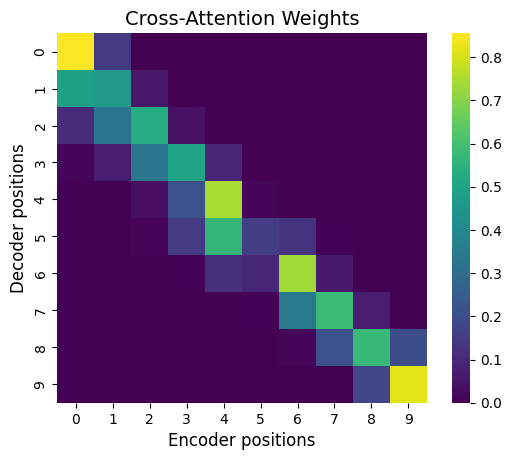

In [8]:
sns.heatmap(
    attn.cpu().numpy(),
    cmap="viridis",
    square=True,
    cbar=True
)

plt.xlabel("Encoder positions", fontsize=12)
plt.ylabel("Decoder positions", fontsize=12)
plt.title("Cross-Attention Weights", fontsize=14)

plt.show()